# Audio

## Task 1

Для начала познакомимся с этими записями. \
Установи библиотеку [librosa](https://librosa.org/). Это популярная библиотека для работы с аудио.
Визуализируй аудио сигнал файла `0_1_0_1_1_1_0_0.wav` с помощью функции [librosa.display.waveshow](https://librosa.org/doc/main/generated/librosa.display.waveshow.html)
График должен быть такой же, как показано ниже (по значениям):

![waveform](../misc/images/waveform.png)
>Для того, чтобы прослушать это аудио файл, можешь воспользоваться [IPython.display.Audio](http://ipython.org/ipython-doc/stable/api/generated/IPython.display.html#IPython.display.Audio)

In [1]:
# pip install librosa

In [37]:
# Код тут
import librosa
import IPython.display as ipd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [38]:
audio_data = r"..\datasets\audio_yes_no\waves_yesno 2\0_1_0_1_1_1_0_0.wav"
y, sr = librosa.load(audio_data)
print(type(y), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [39]:
print(y.shape, sr)

(153909,) 22050


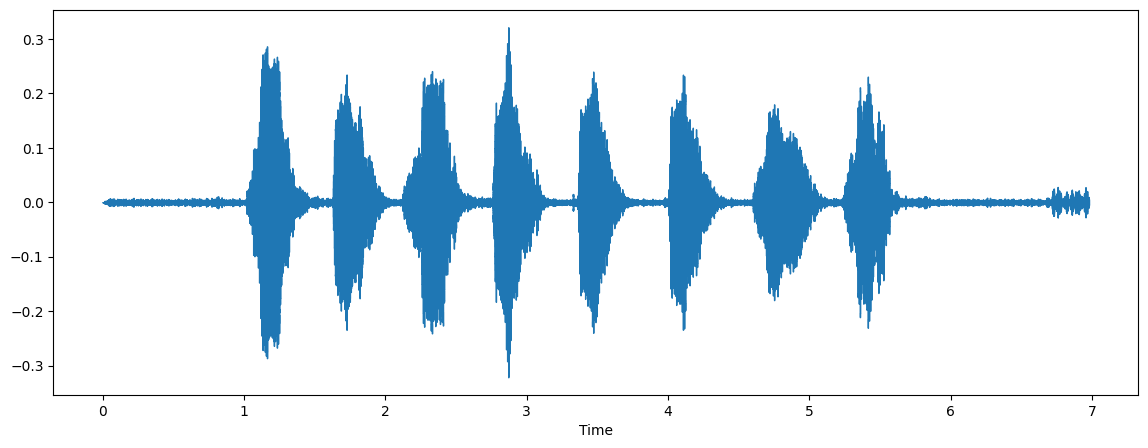

In [40]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
ipd.Audio(audio_data)


## Task 2

Для классификации обычно использует не просто аудио сигнал, а его частотно-временное представление. Для этого сигнал требуется
преобразовать с помощью [оконного преобразования Фурье](https://clck.ru/34JnZD).
С помощью функции [librosa.display.specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html) 
выведи спектрограмму сигнала. \
График должен быть такой же, как показано ниже (по значениям):
![sftp](../misc/images/sftp.png)

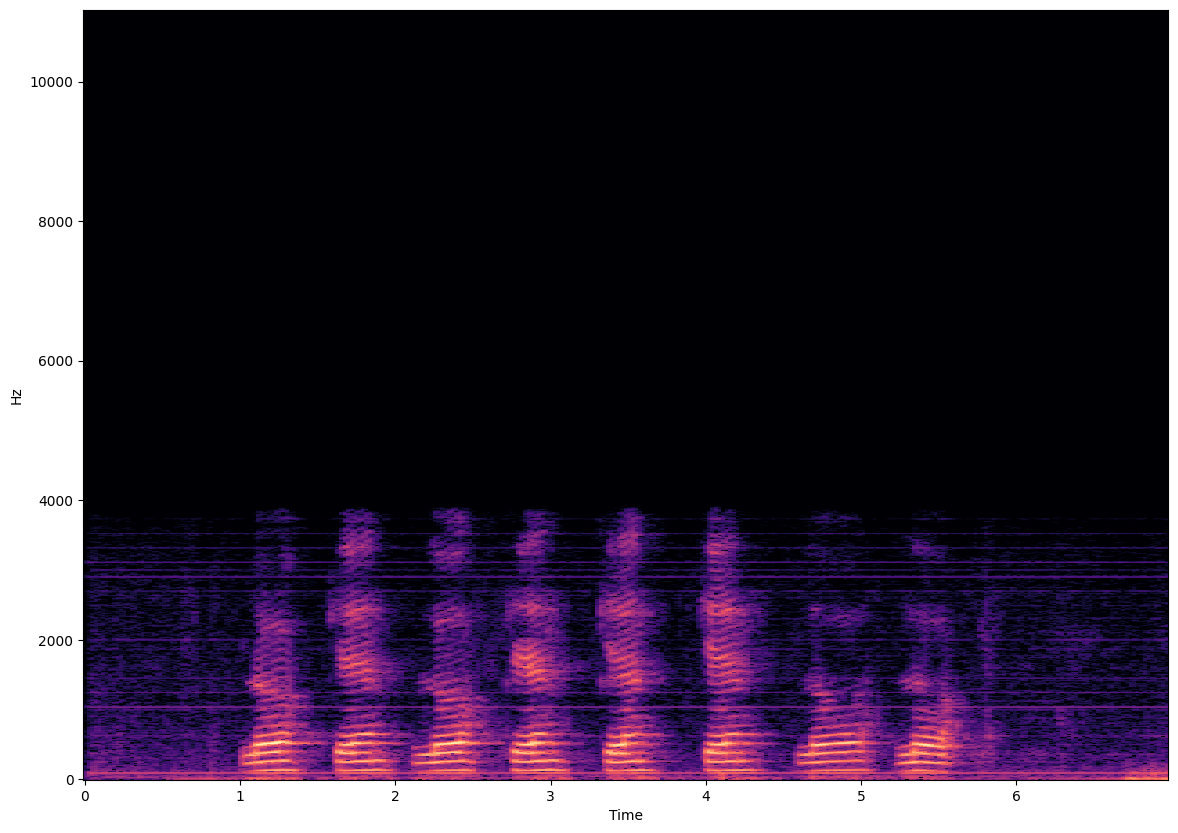

In [41]:
# Код тут
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 10))
librosa.display.specshow(Xdb, sr=sr , x_axis='time', y_axis="hz")
# plt.colorbar()


## Task 3

C помощью функции [load_dataset](code-samples/audio_utils.py) загрузи датасет. \
Раздели его на train и test c параметрами `test_size=0.2`, `random_state=42`. \
Выведи количество файлов в train и test частях.

In [42]:
def load_dataset(directory: str):
    sr = None
    X, labels, files = [], [], []
    for f in glob(directory + "\*.wav"):
        filename = os.path.basename(f)
        name = filename[:-4]
        y = [int(label) for label in name.split("_")]
        x, sr = librosa.load(f)
        X.append(x)
        labels.append(y)
        files.append(filename)

    return X, labels, sr, files

In [43]:
# Код тут
direc = r"..\datasets\audio_yes_no\waves_yesno 2"
X, labels, sr, files = load_dataset(direc)

#print(X)
#print(labels)
#print(sr)
#print(len(files))

X_train, X_test, labels_train, labels_test, files_train, files_test = train_test_split(X, labels, files, test_size=0.2, random_state=42)

print("Количество файлов в обучающей выборке:",len(files_train))
print("Количество файлов в тестовой выборке:",len(files_test))

Количество файлов в обучающей выборке: 47
Количество файлов в тестовой выборке: 12


## Task 4

Наши аудио записи содержат как речь человека, так и молчание. Для каждой записи нам нужно определить сегменты записи, 
где человек молчит, а где произносит слова. \
Эта задача называется [Voice Activity Detection (VAD)](https://ru.wikipedia.org/wiki/Voice_Activity_Detection).
Придумайте или найдите метод, по которому можно распознавать участки с речью на аудио записи.

Например:
Запись '0_0_0_1_0_1_1_0.wav' содержит 137592 отсчетов. Сегменты с речью для этой записи (Отмечены красным):
[[23996, 32539],
 [35410, 44925],
 [49493, 57410],
 [60458, 68635],
 [73308, 81278],
 [84001, 91942],
 [97381, 104166],
 [109018, 115573]] 
![sftp](../misc/images/vad.png)

Выведи несколько примеров работы твоего VAD-алгоритма, по аналогии с примером, для других аудио записей. Попробуй добиться
наилучшего качества нахождения речи.

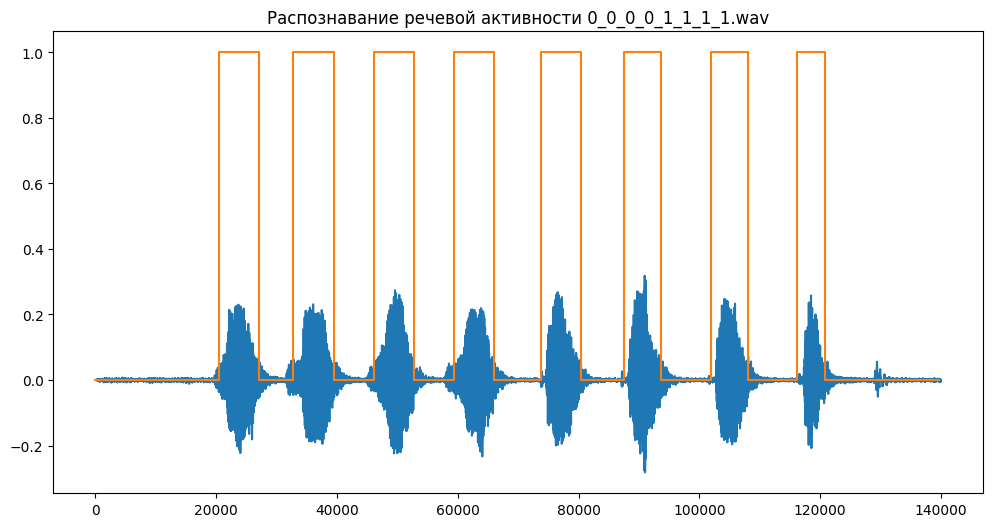

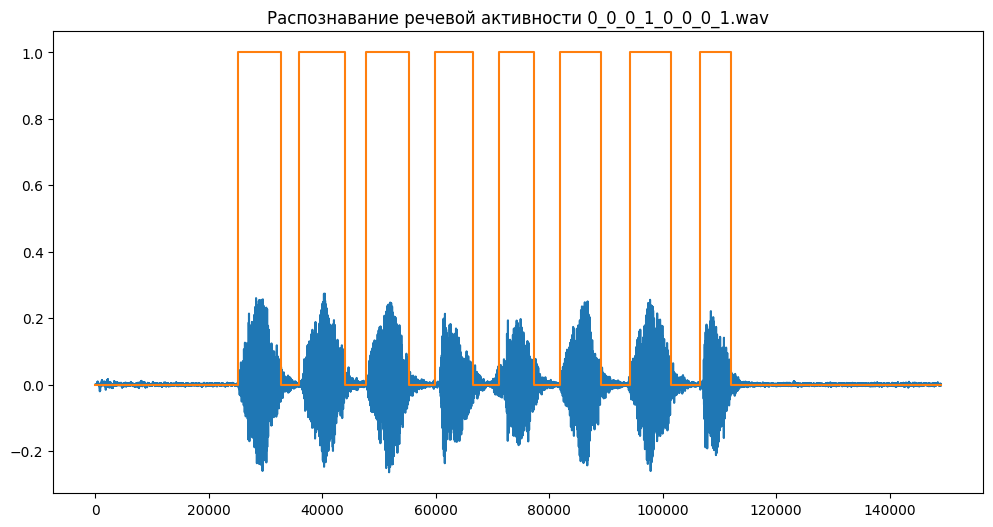

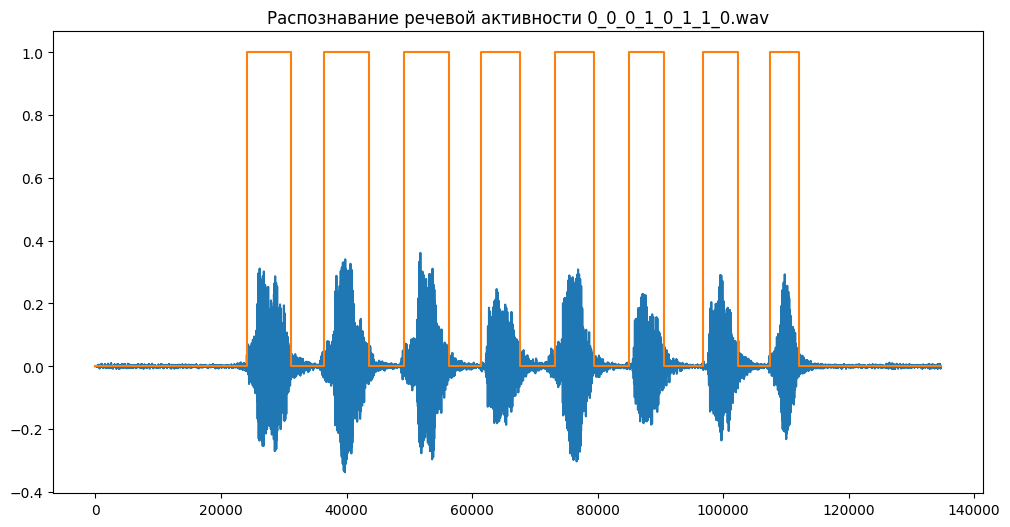

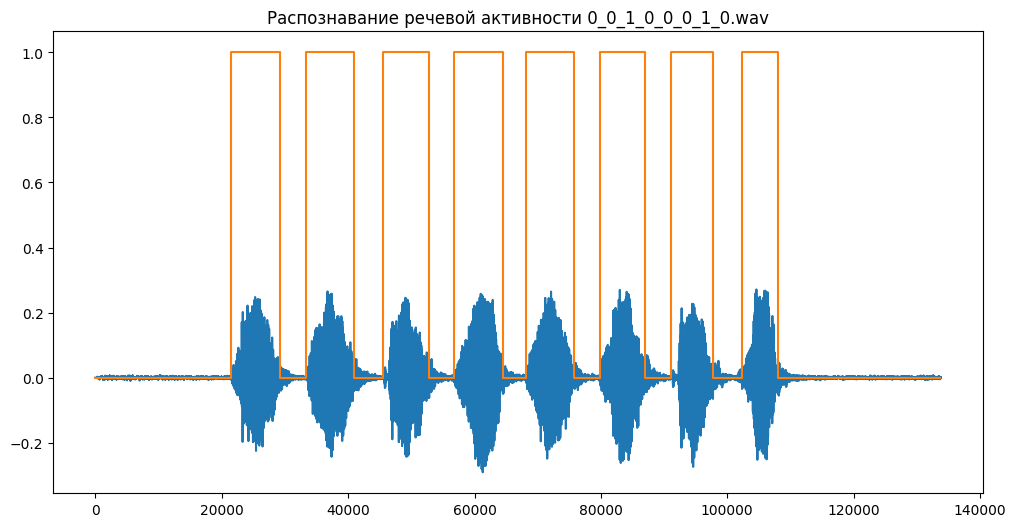

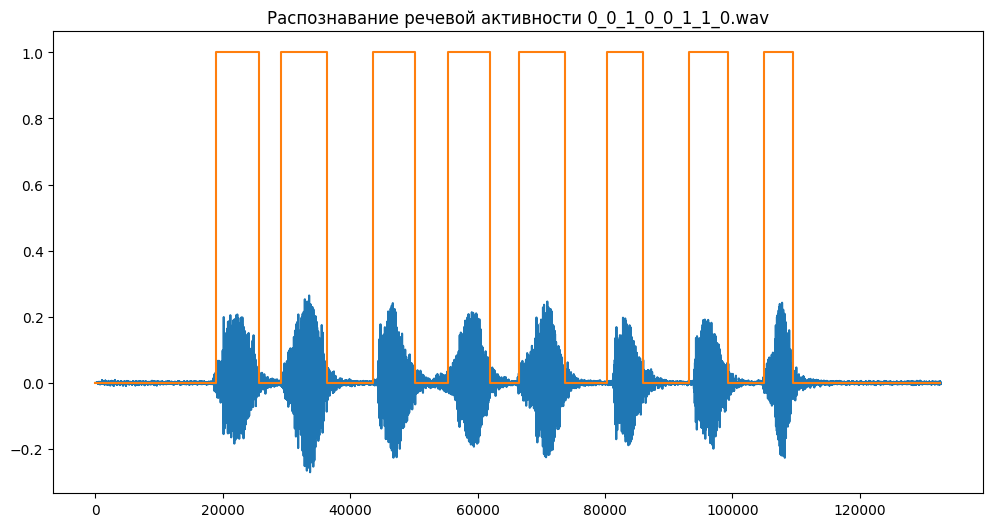

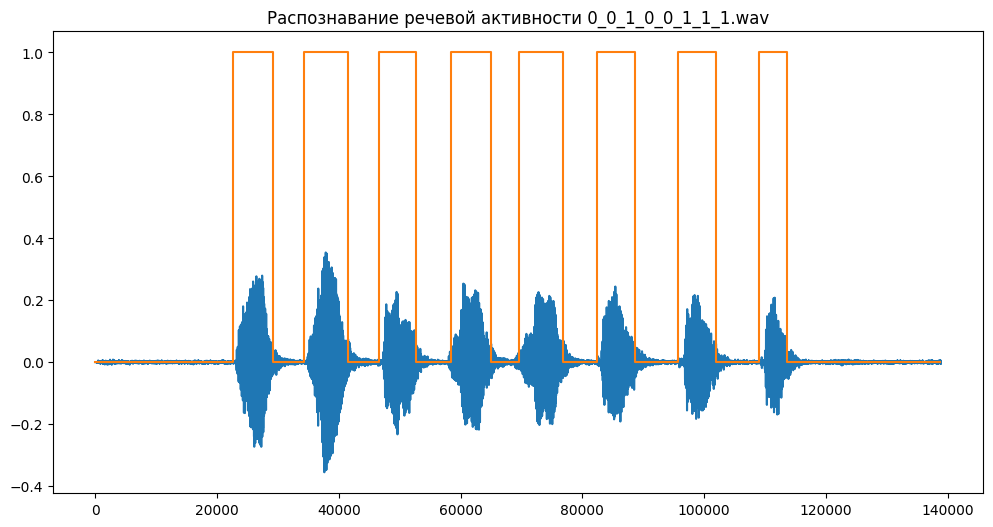

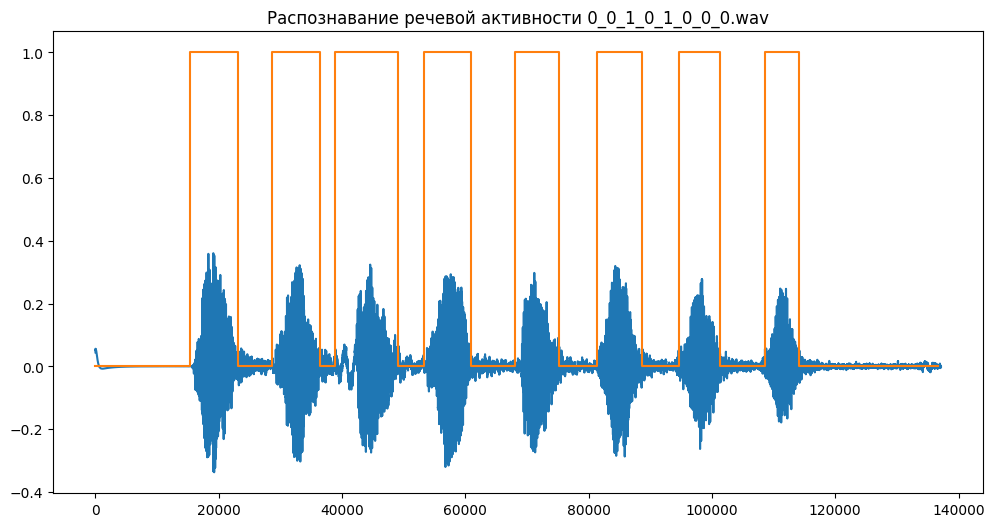

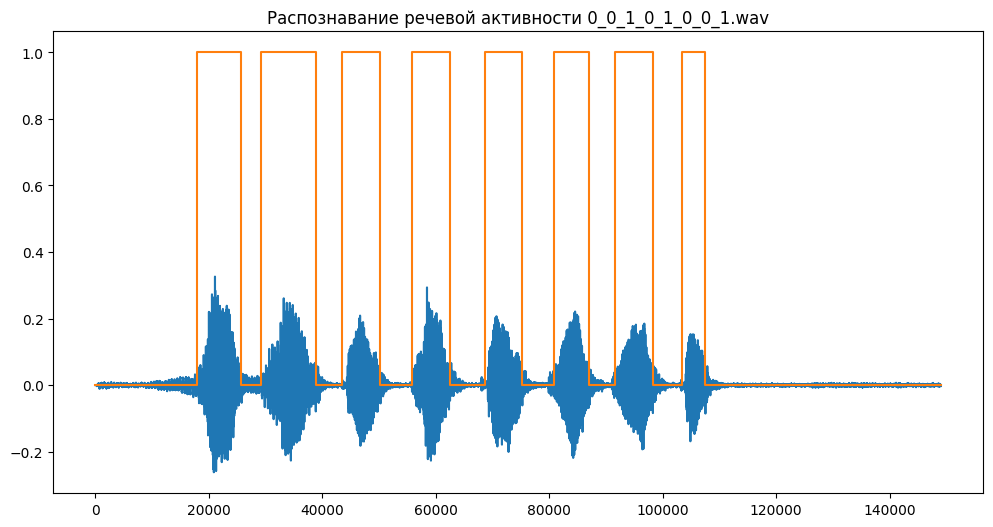

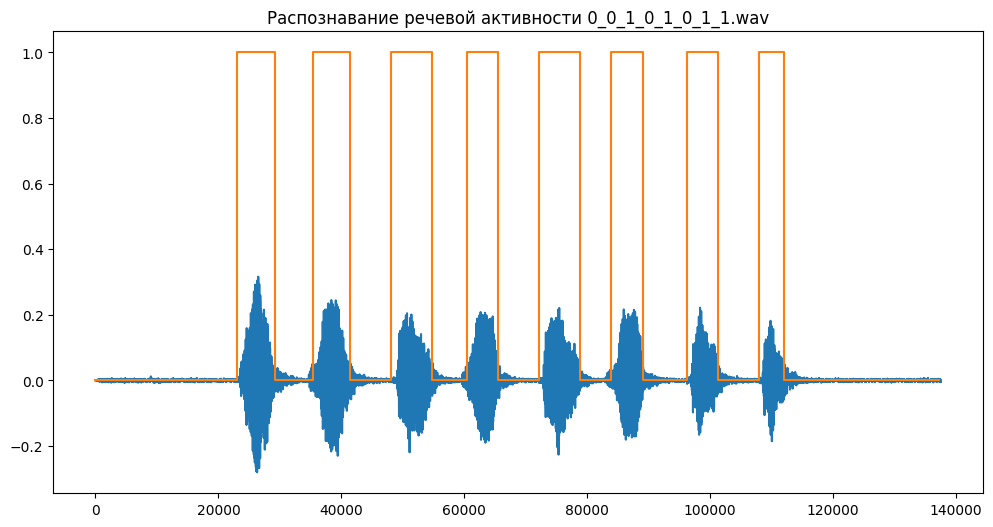

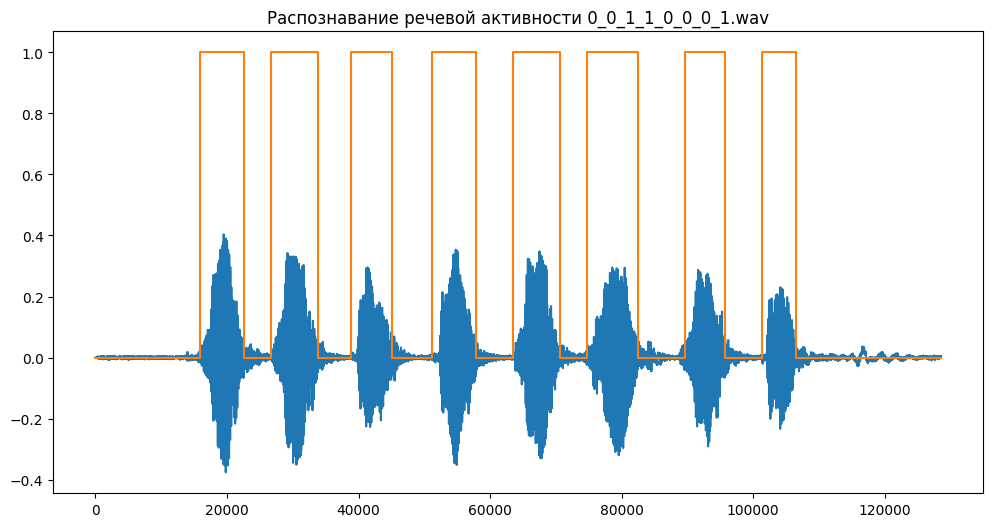

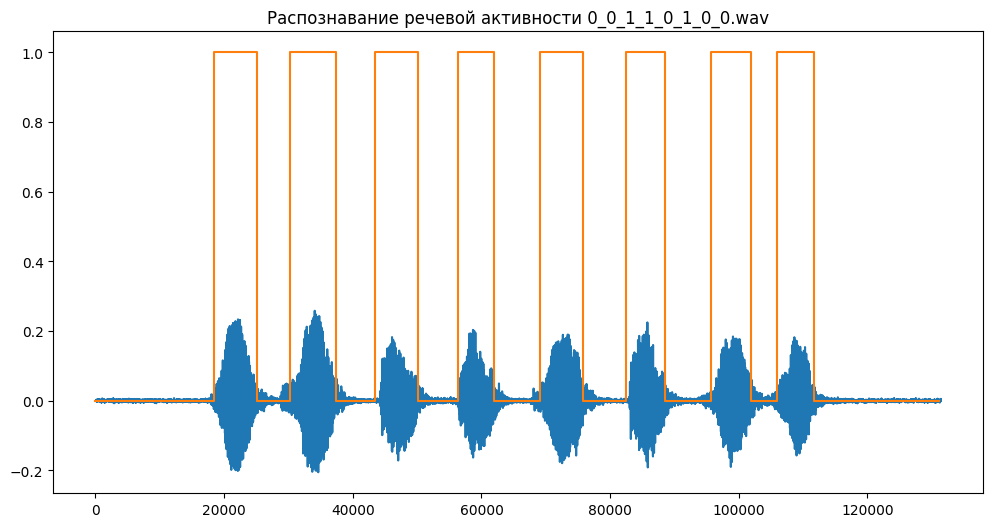

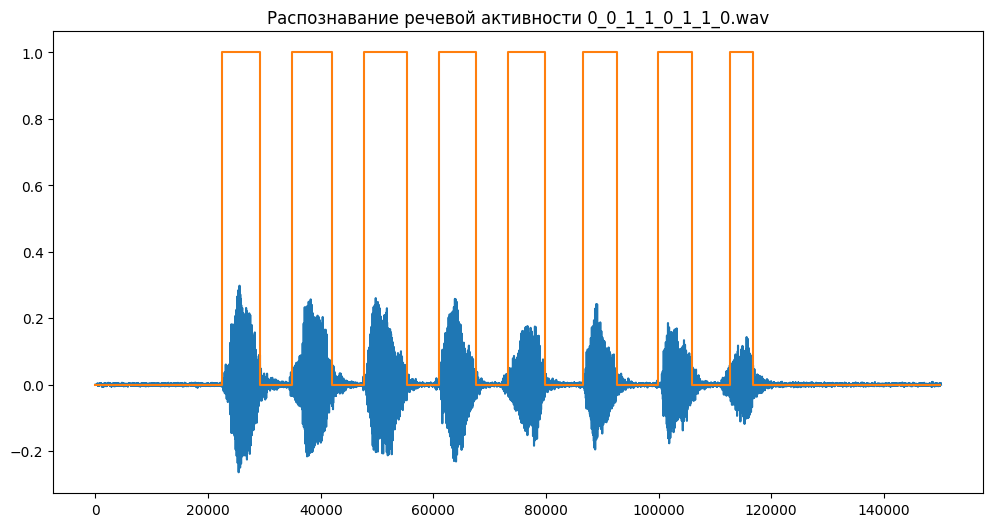

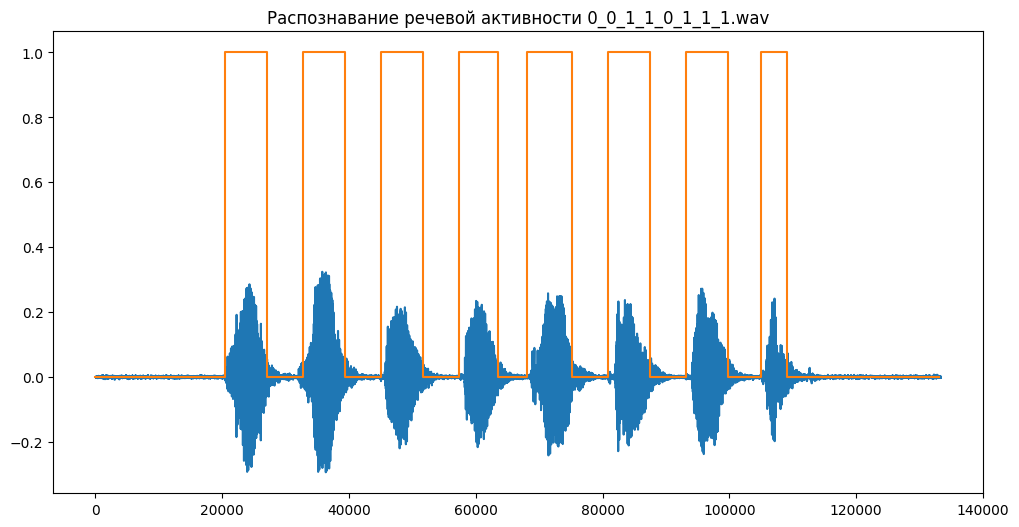

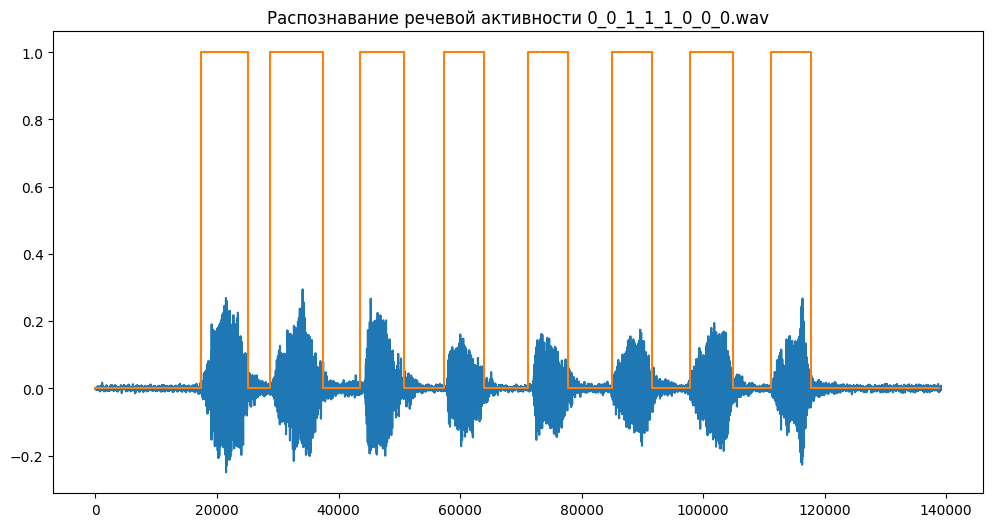

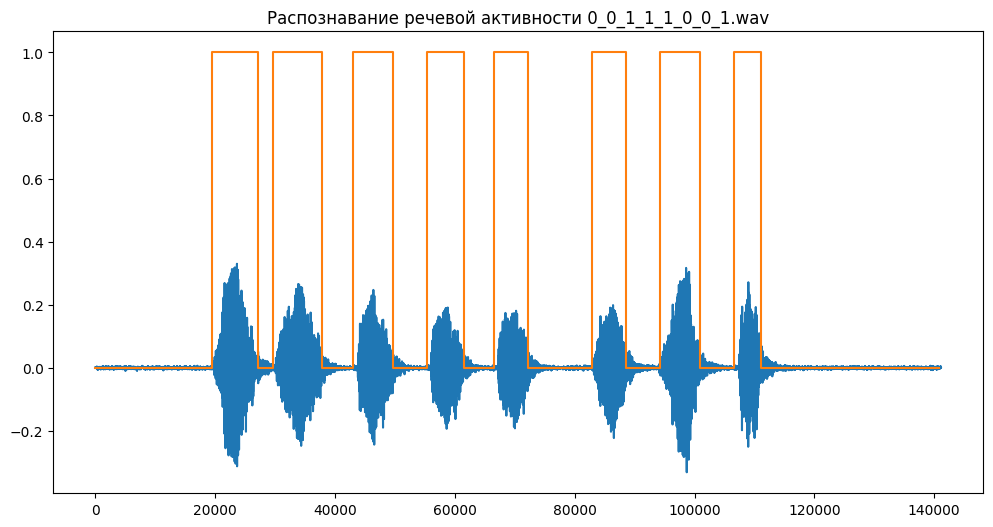

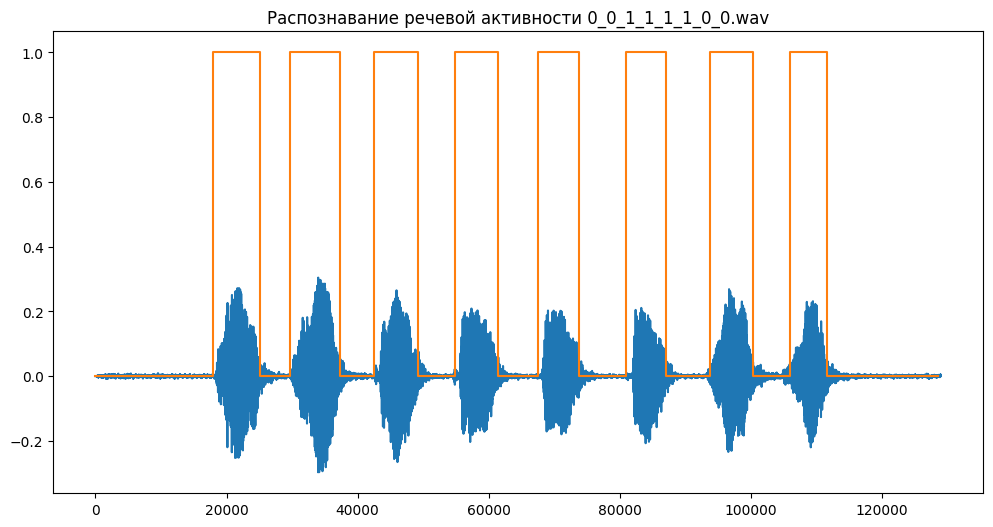

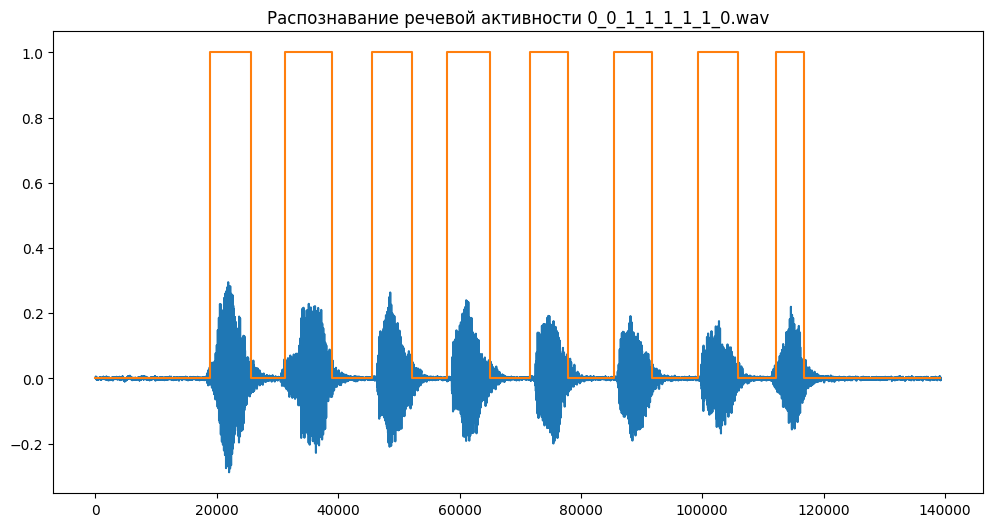

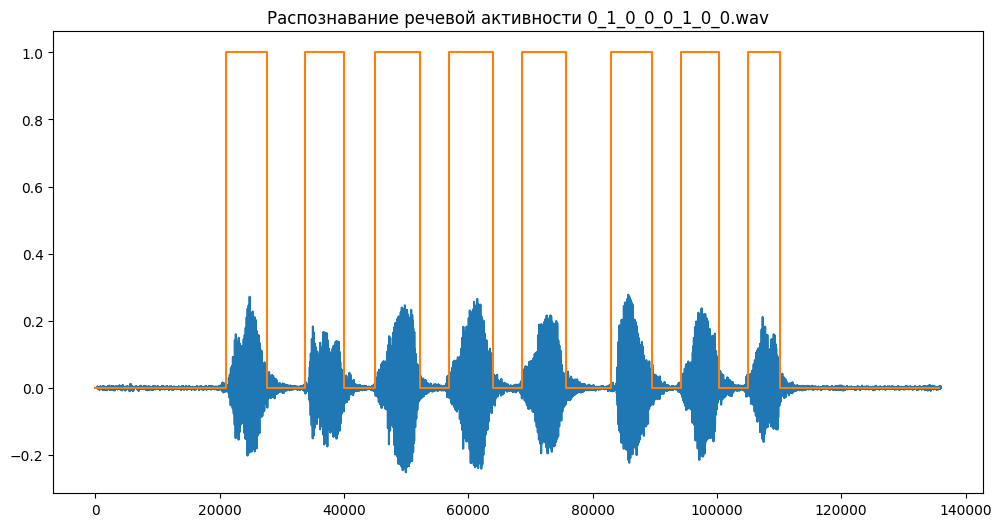

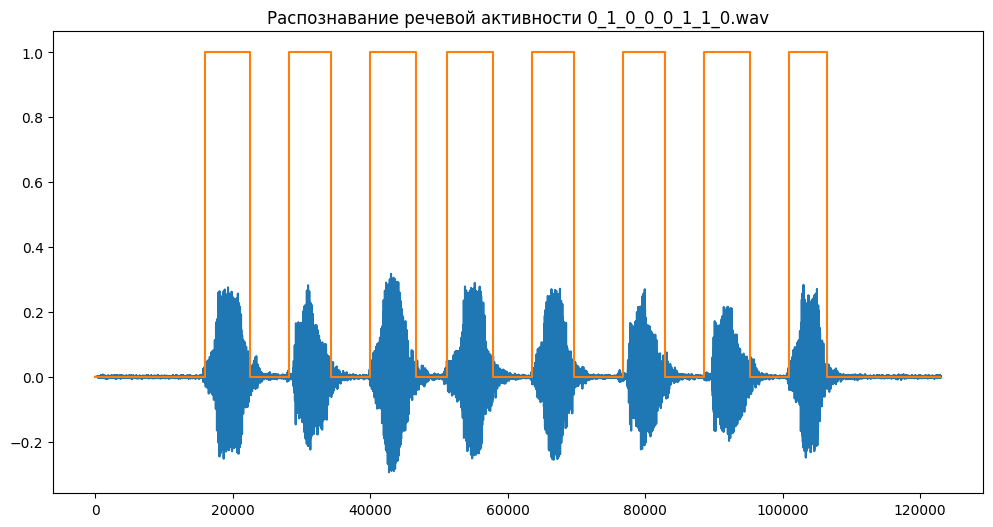

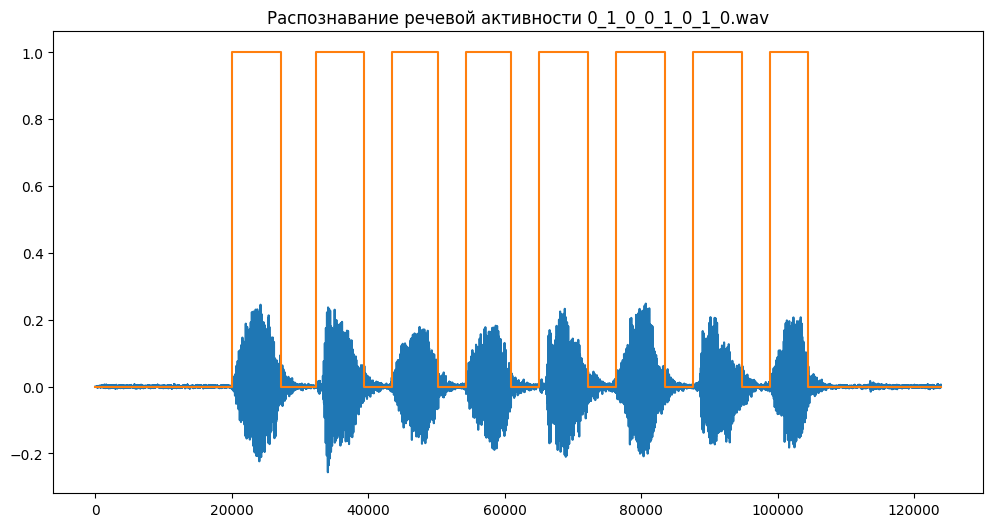

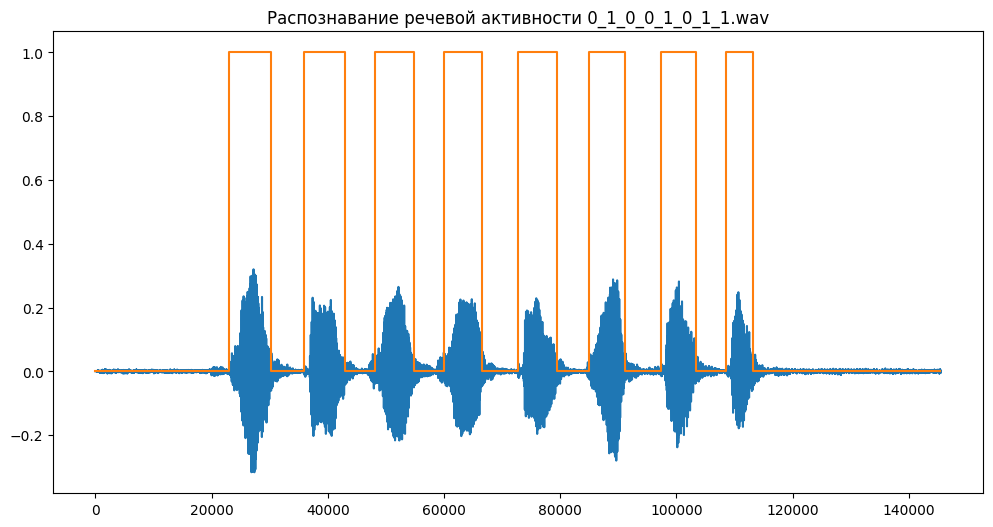

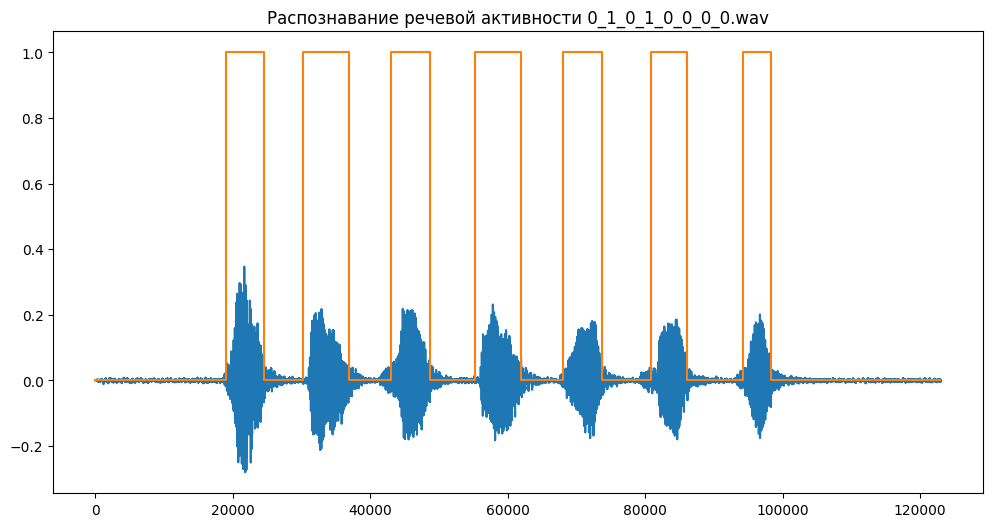

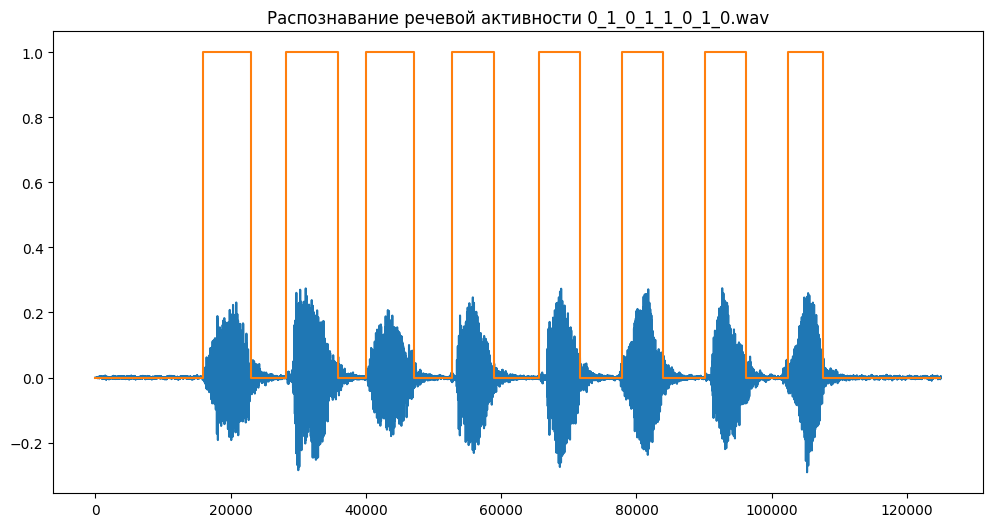

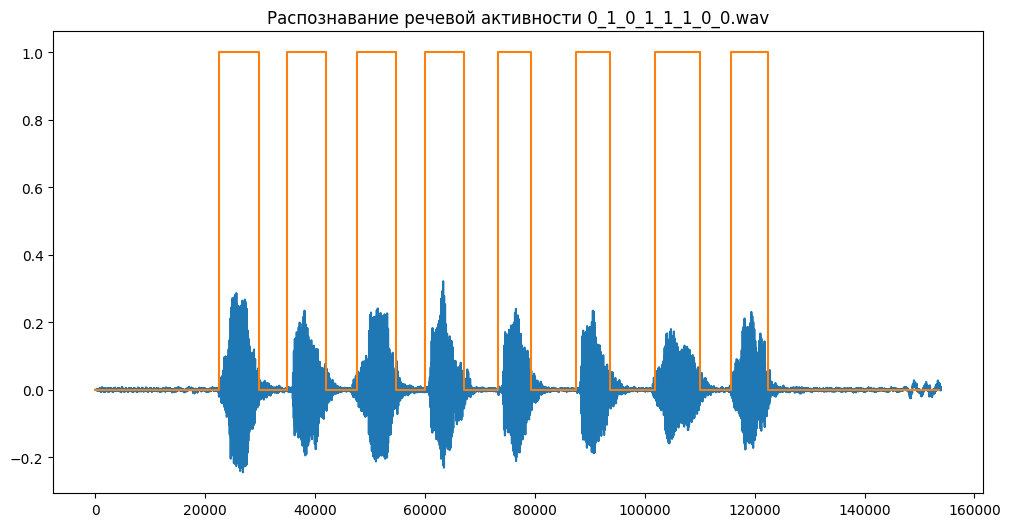

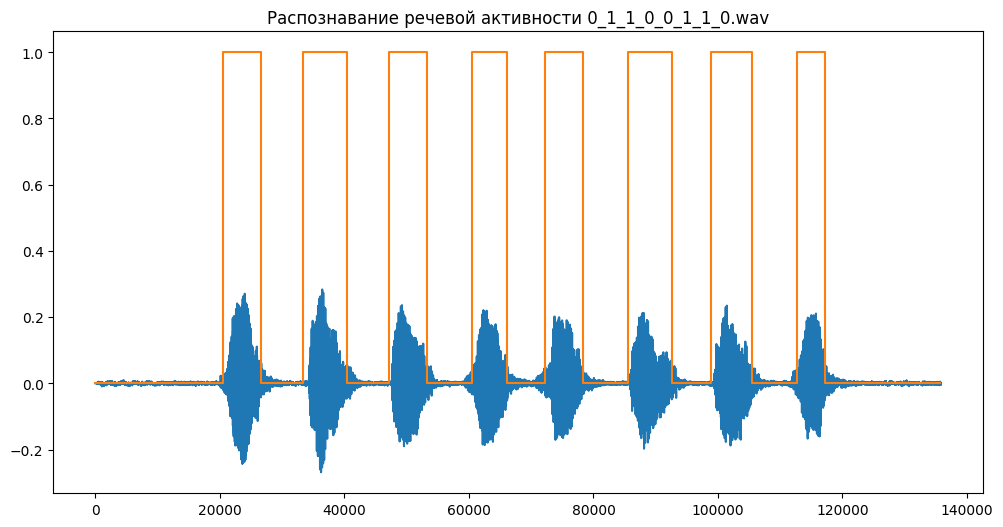

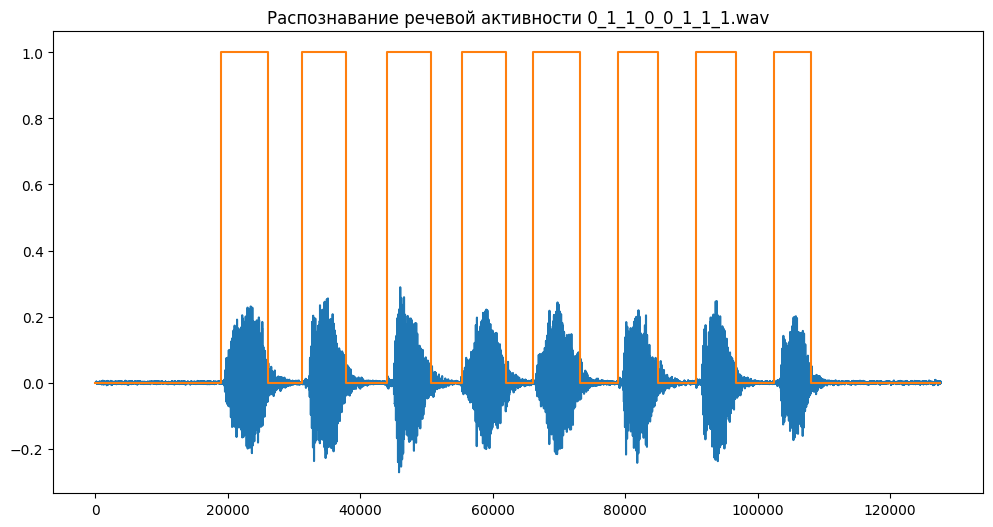

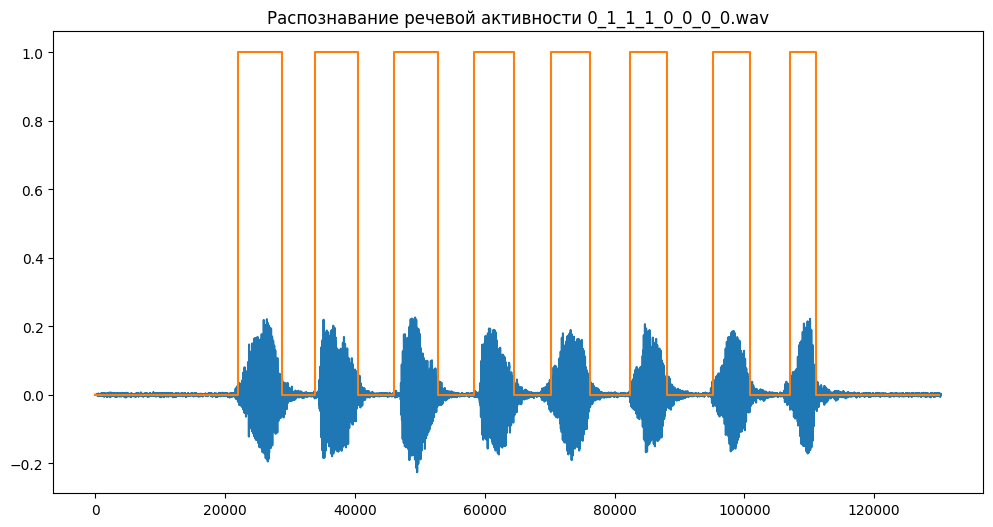

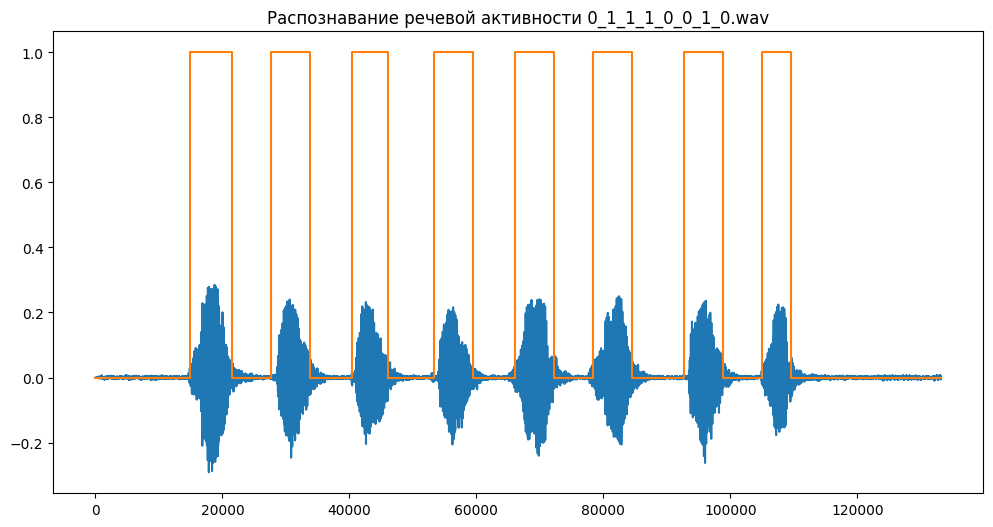

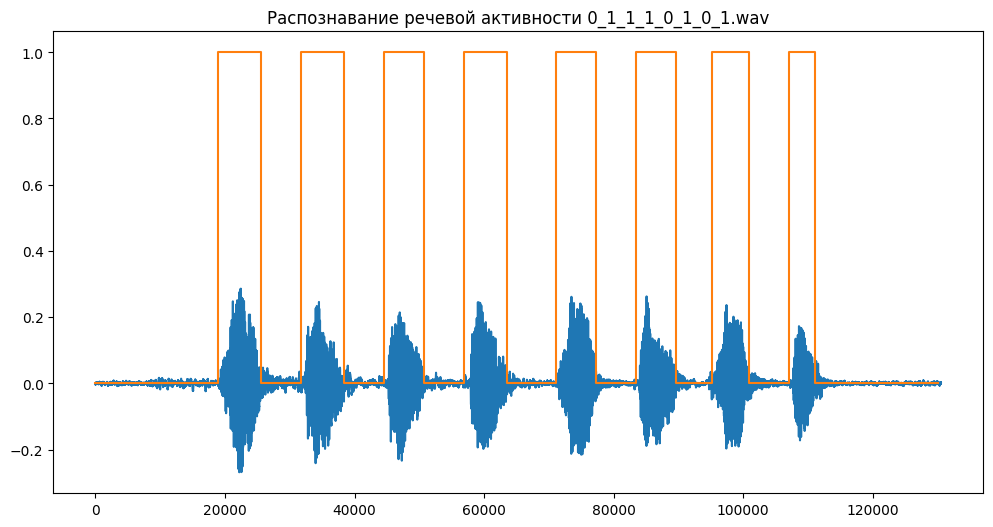

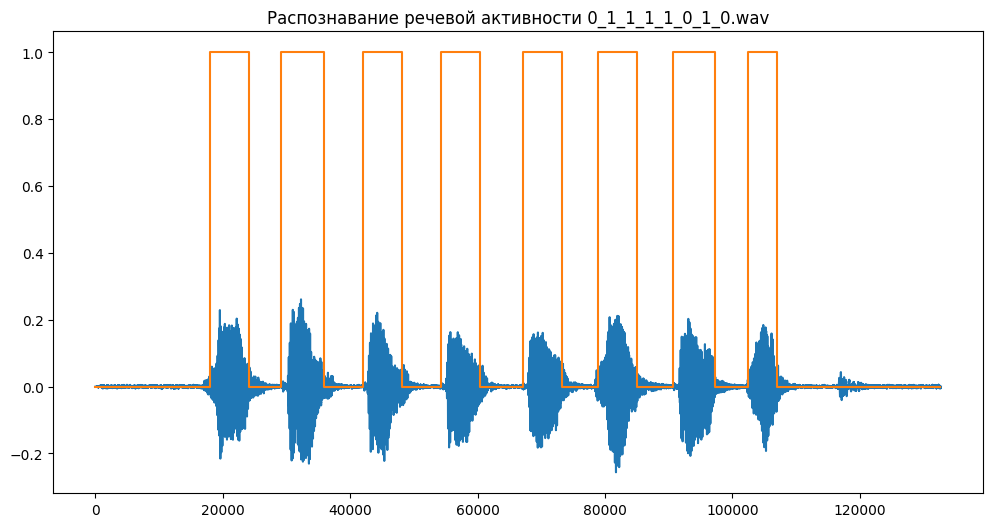

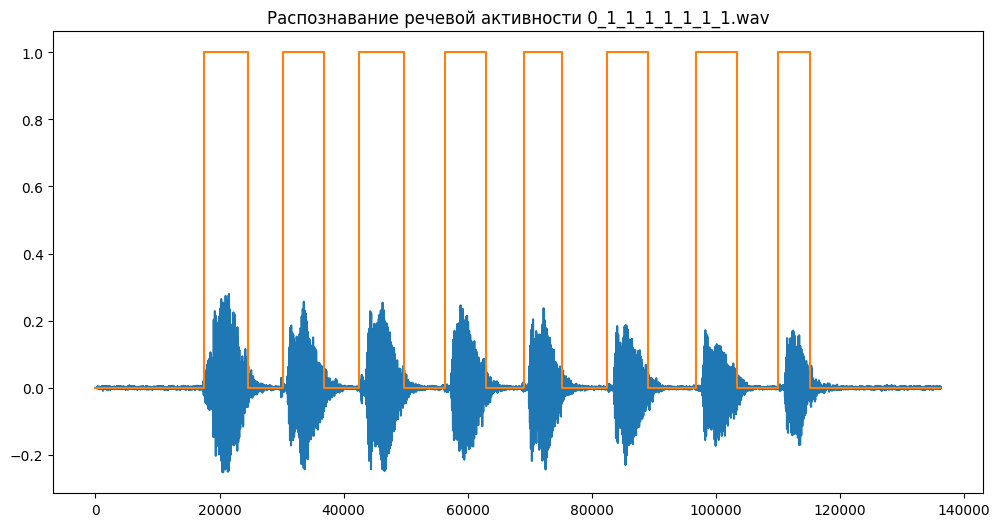

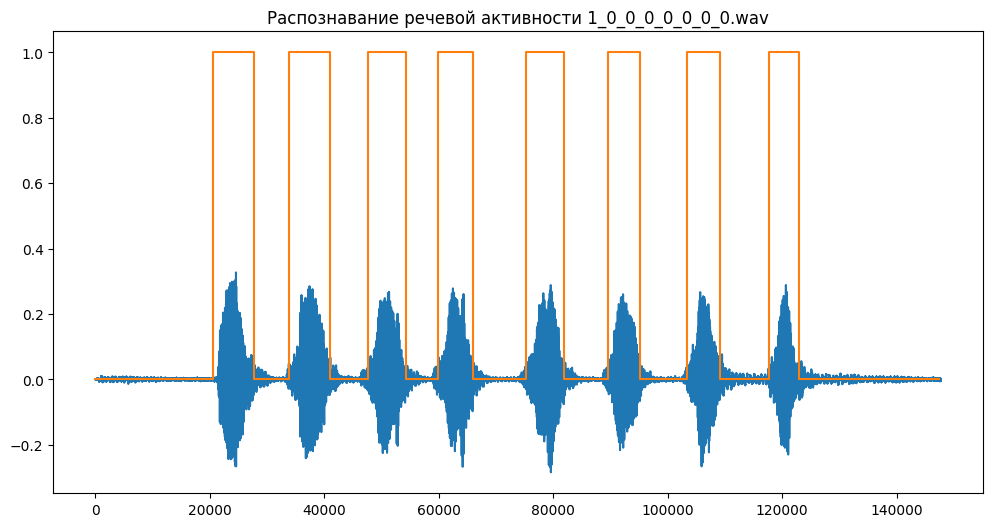

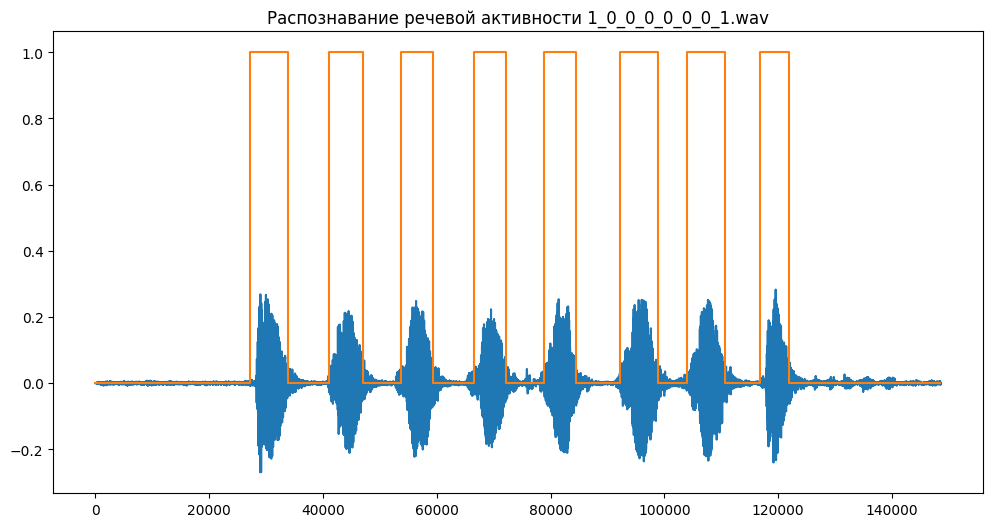

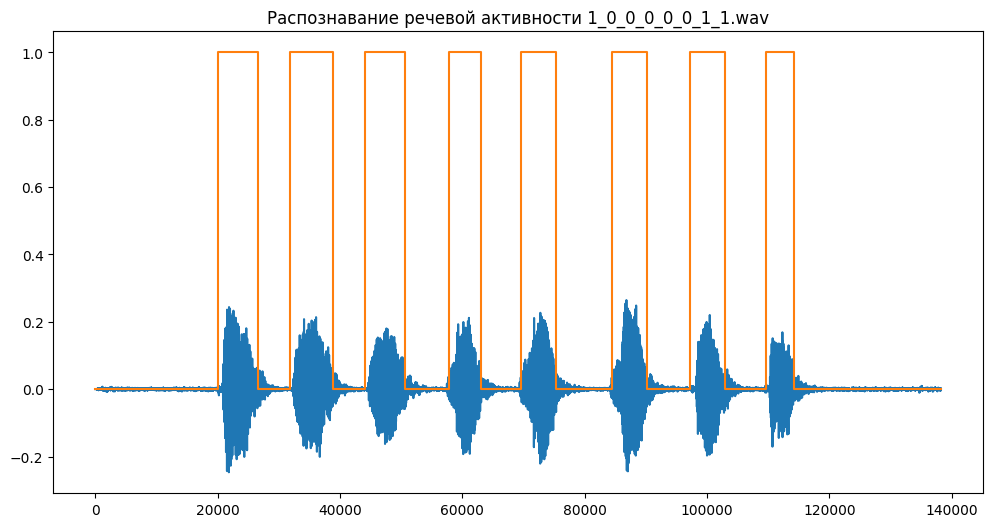

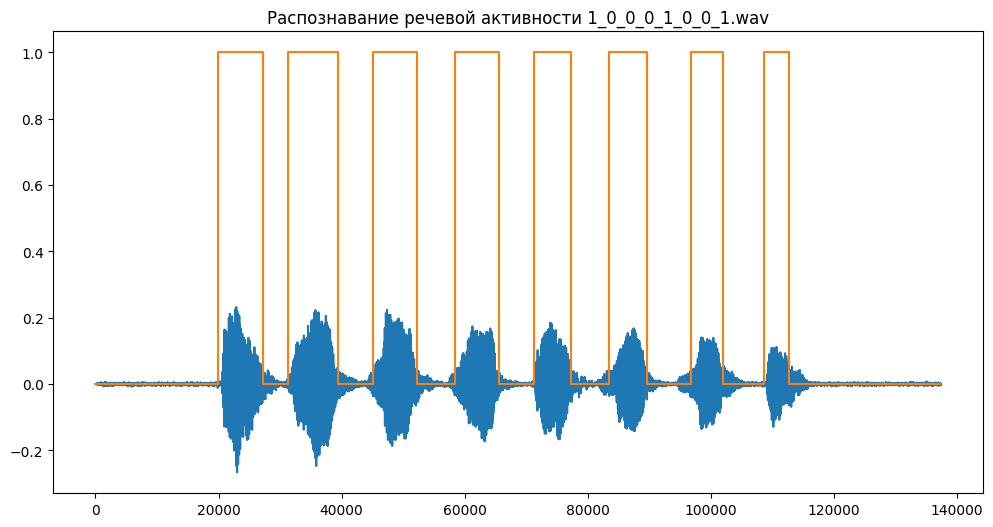

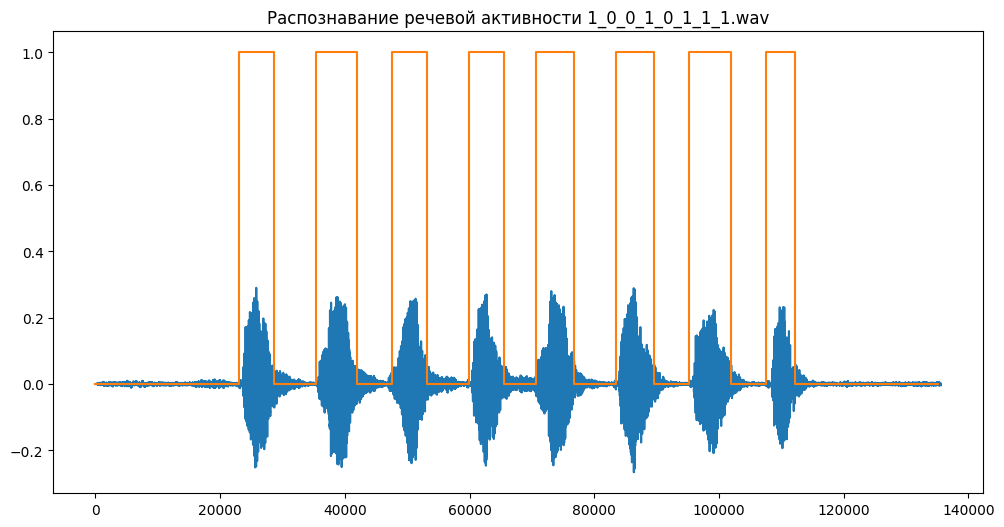

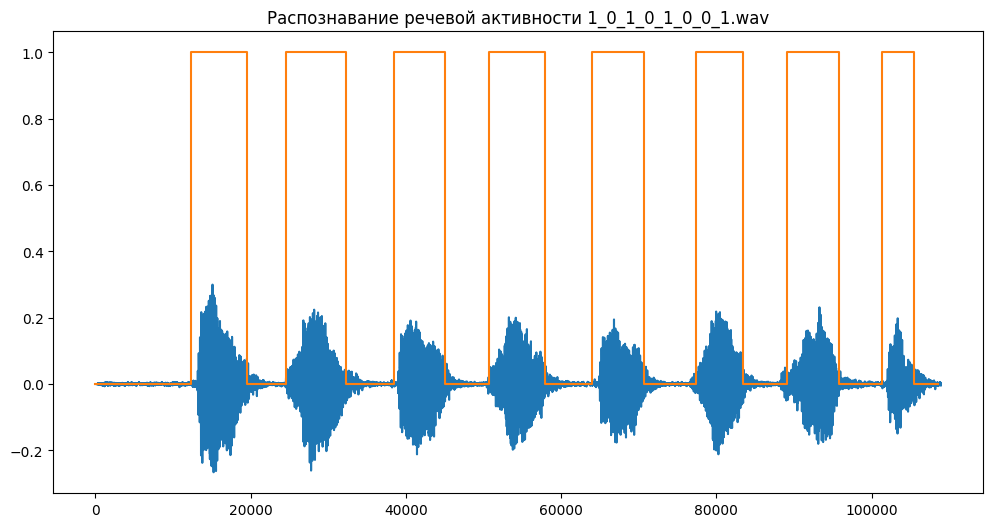

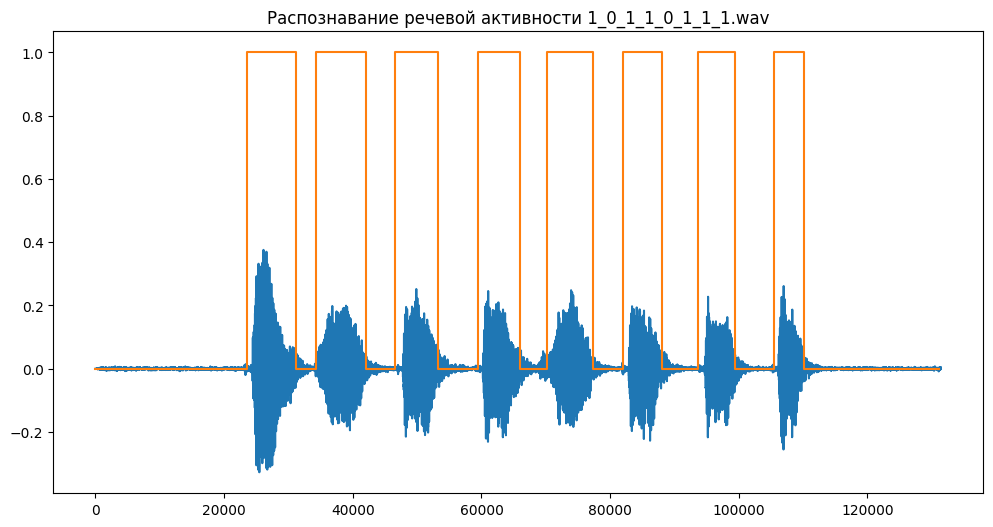

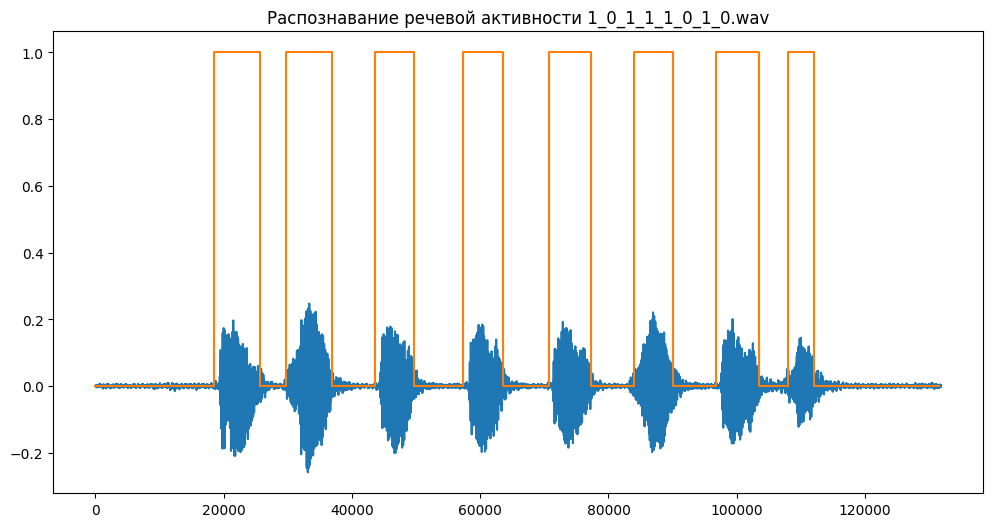

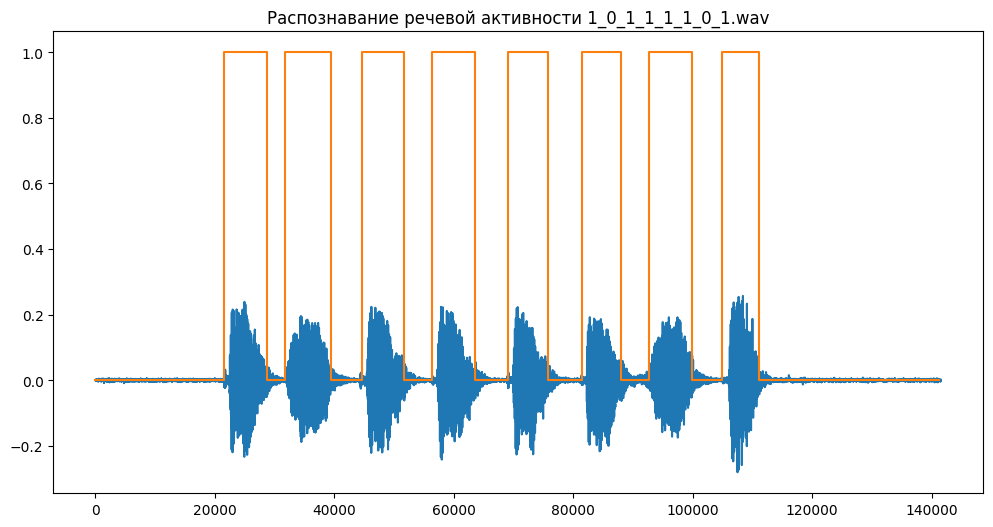

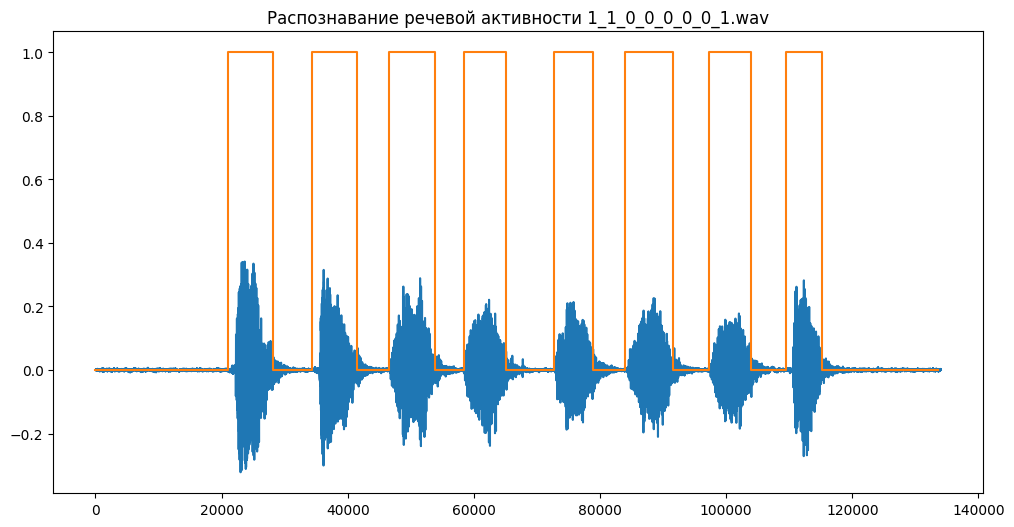

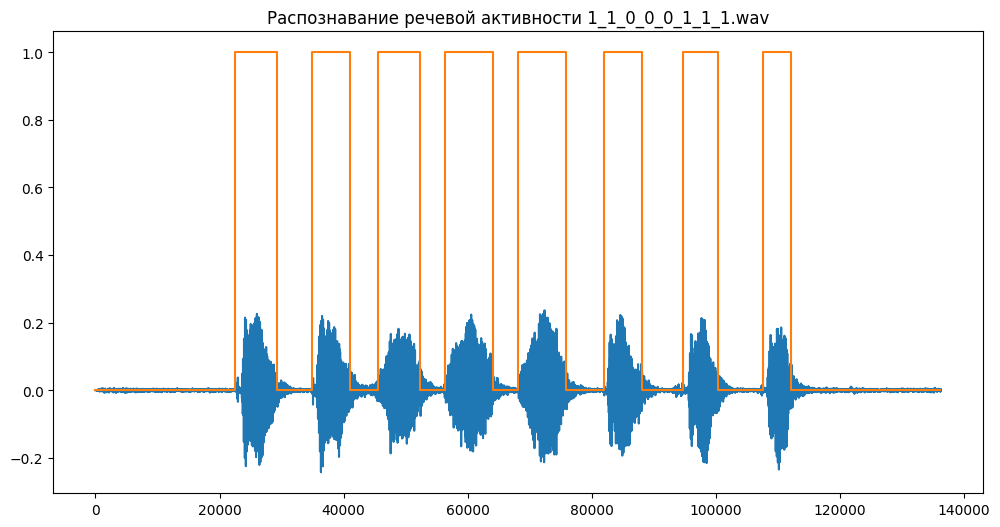

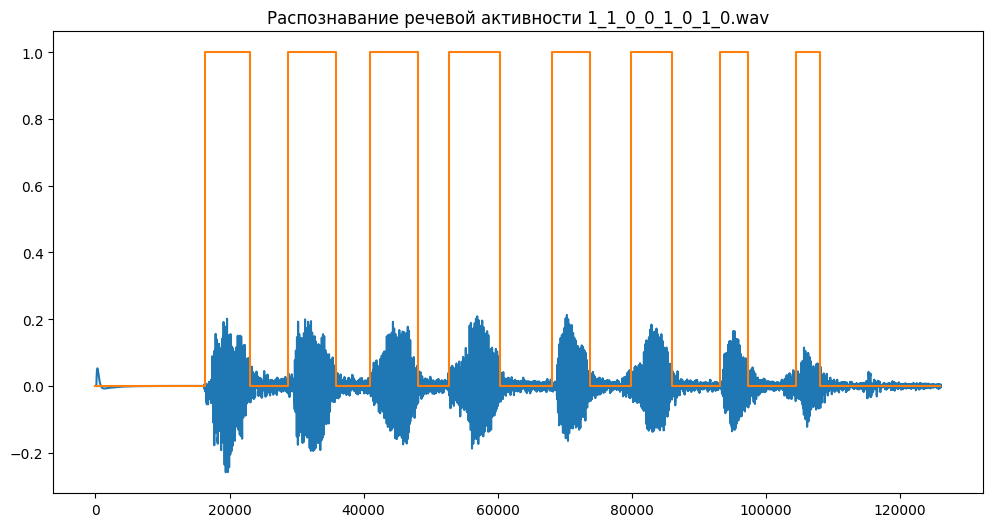

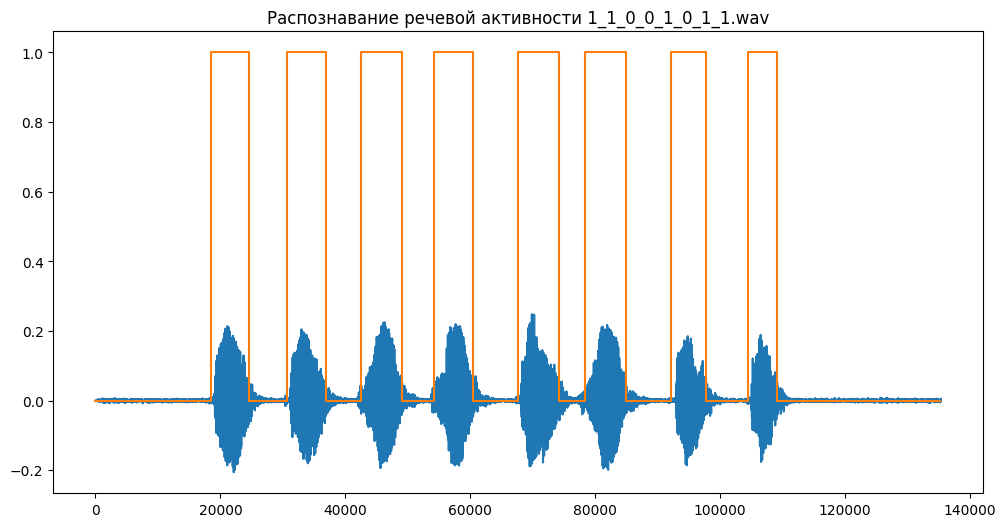

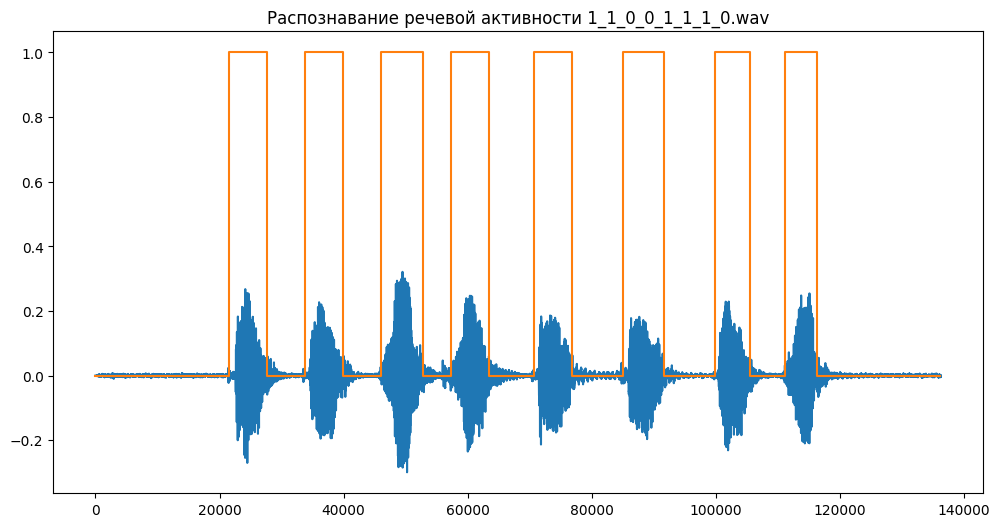

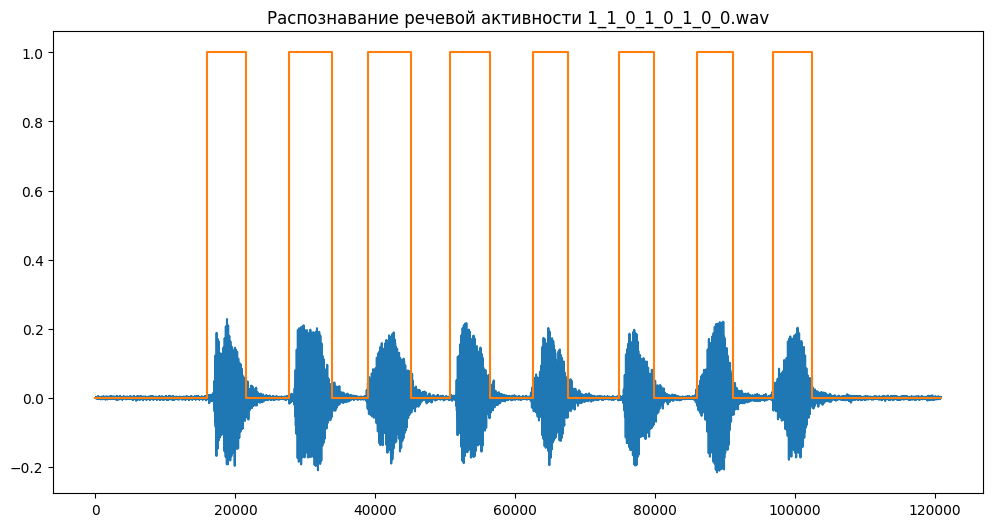

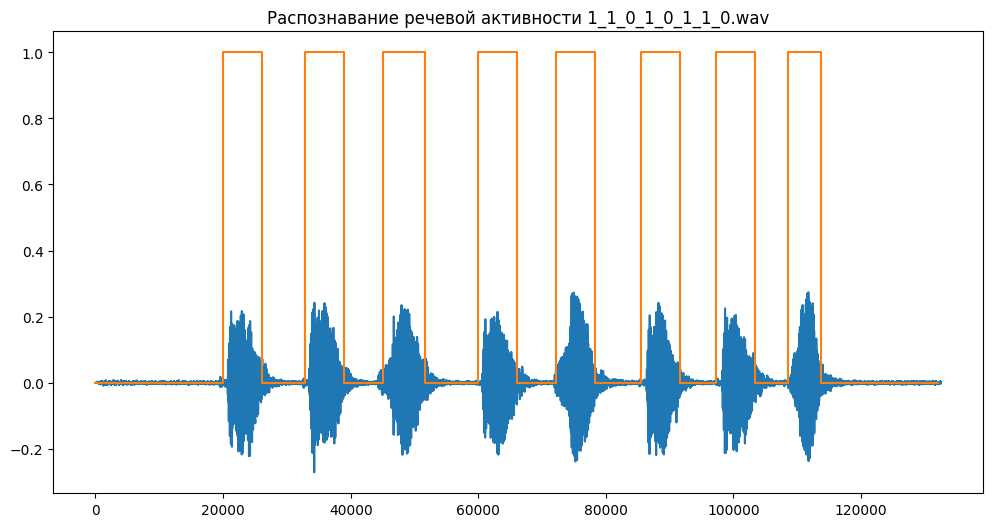

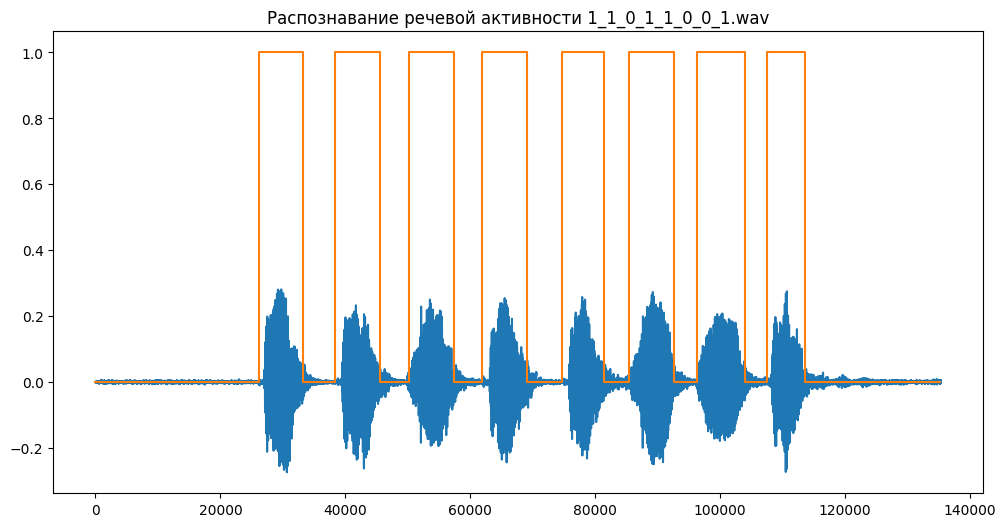

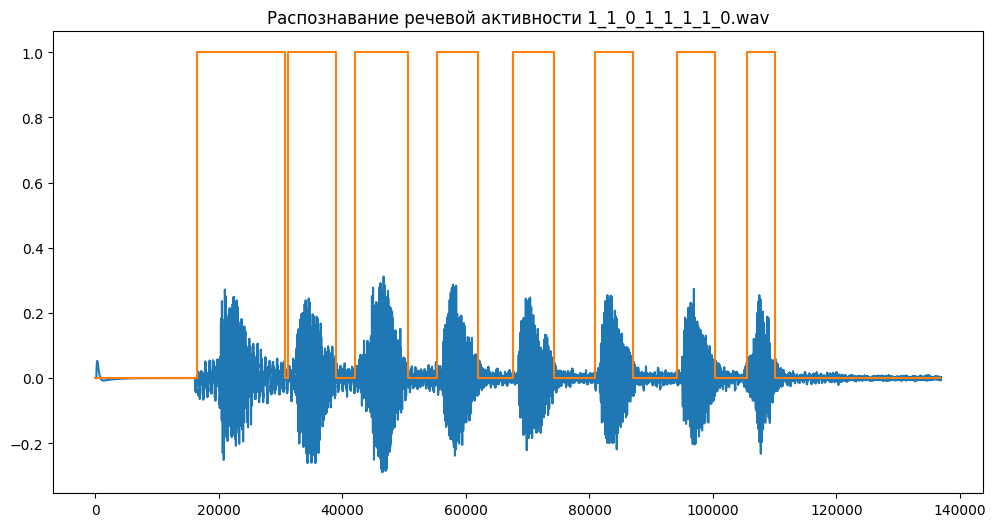

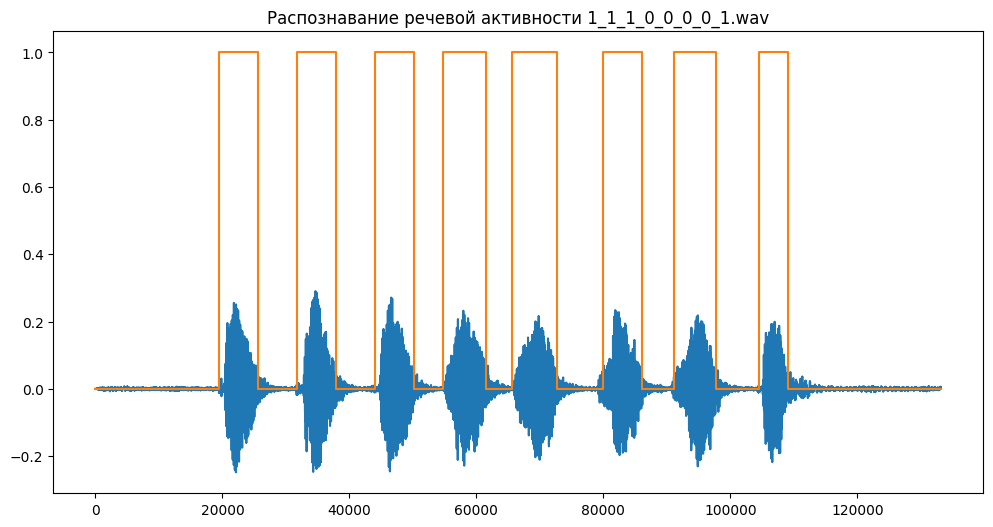

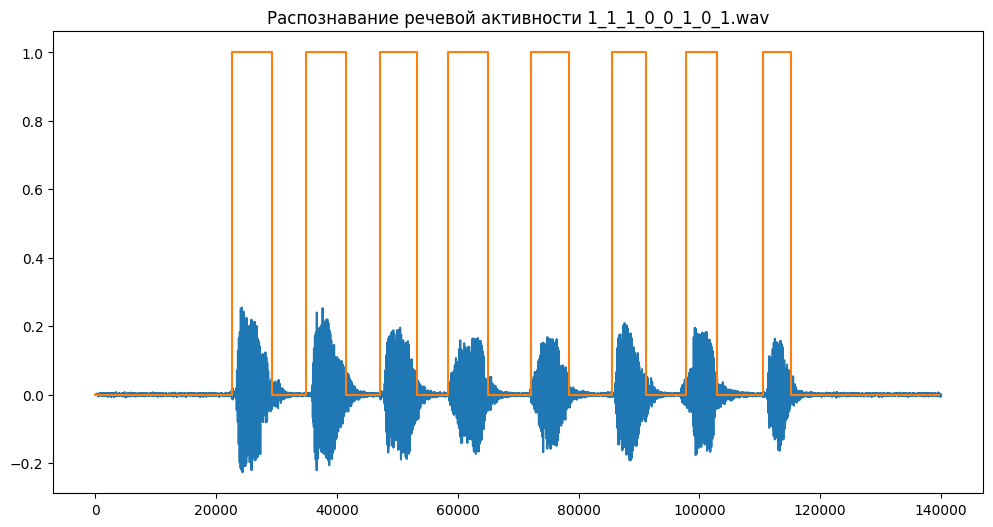

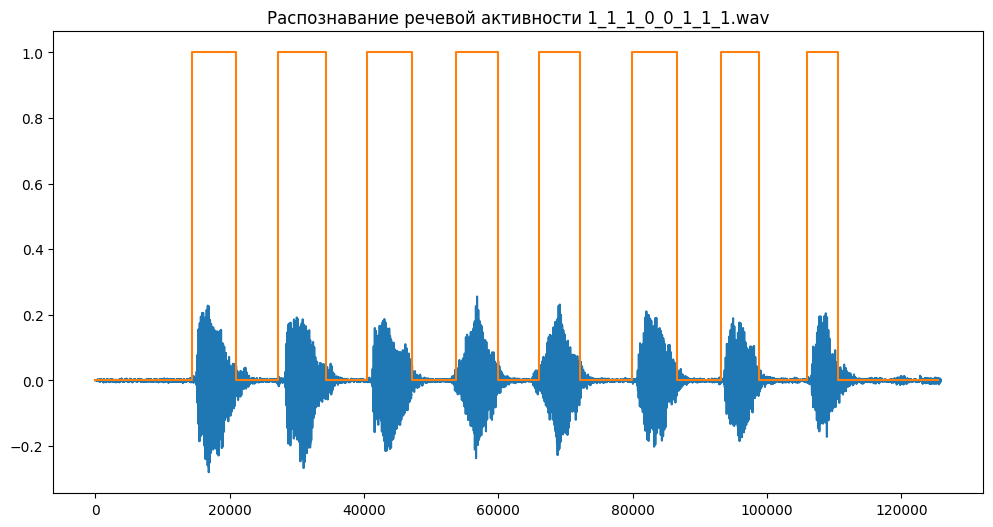

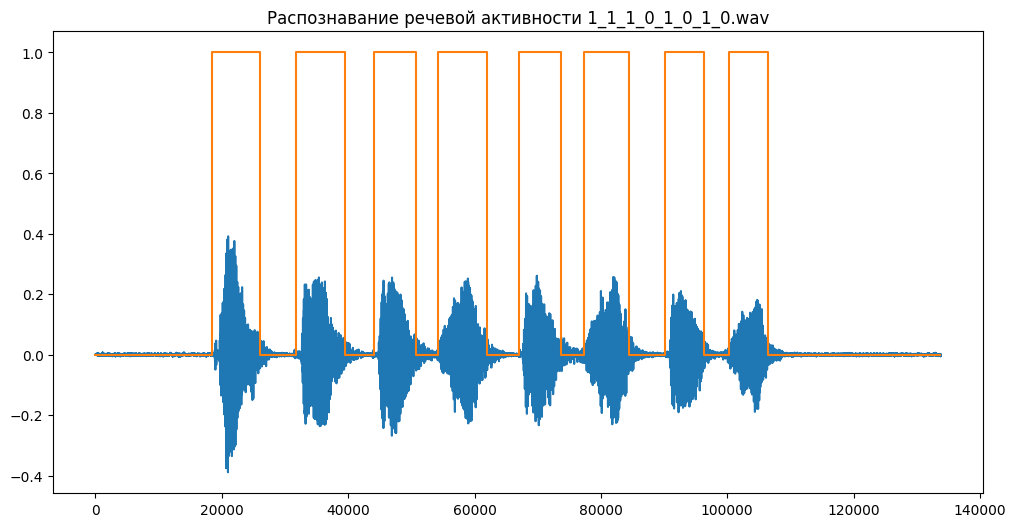

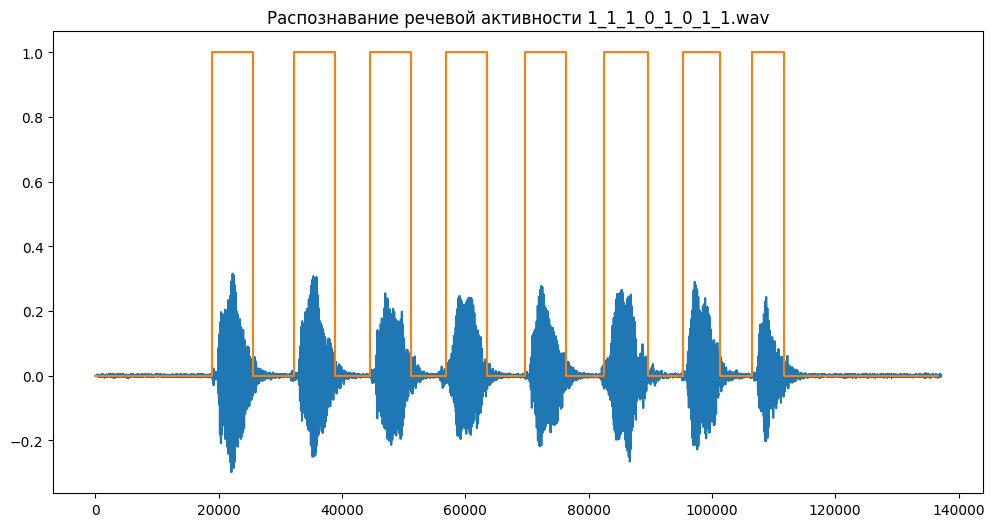

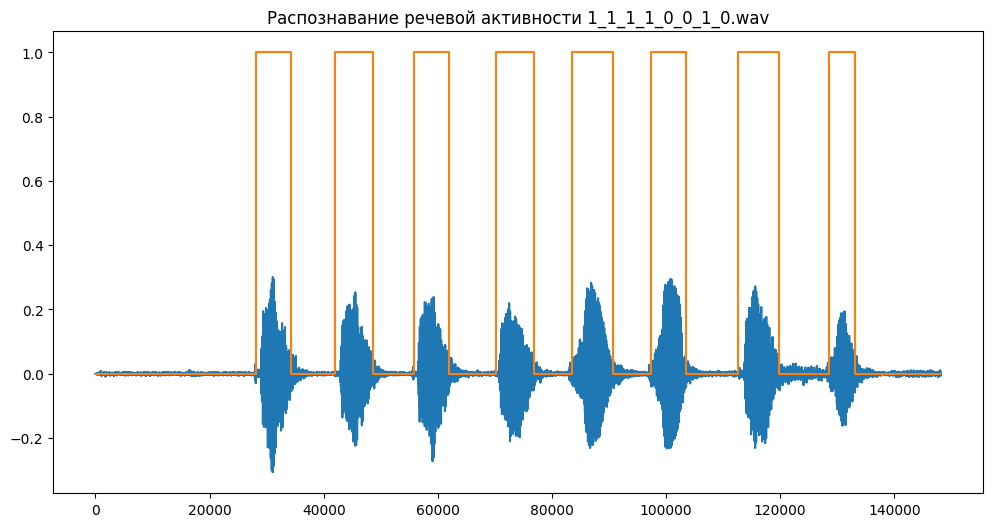

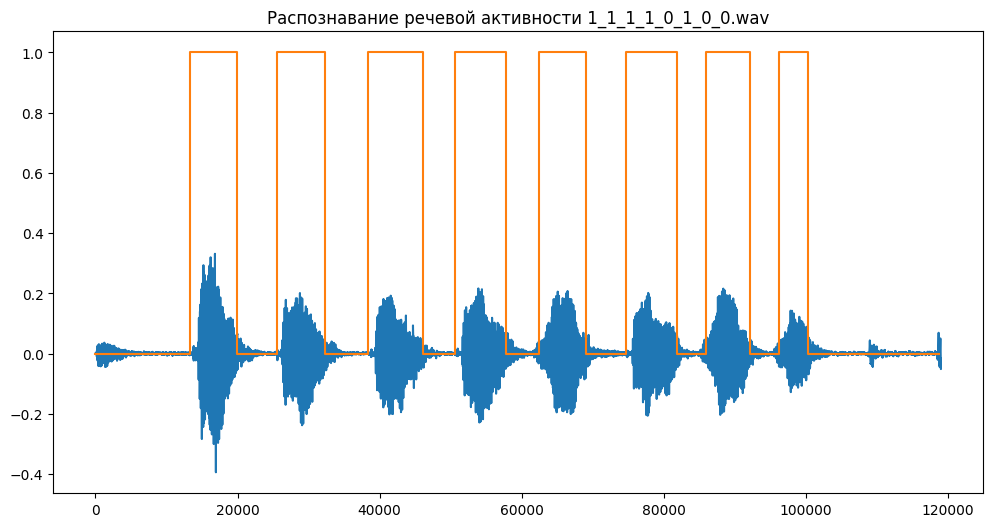

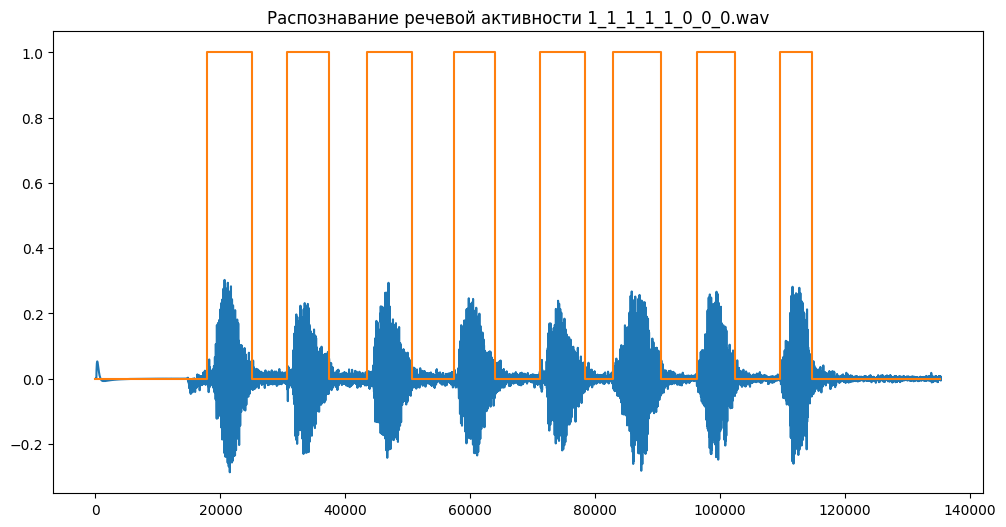

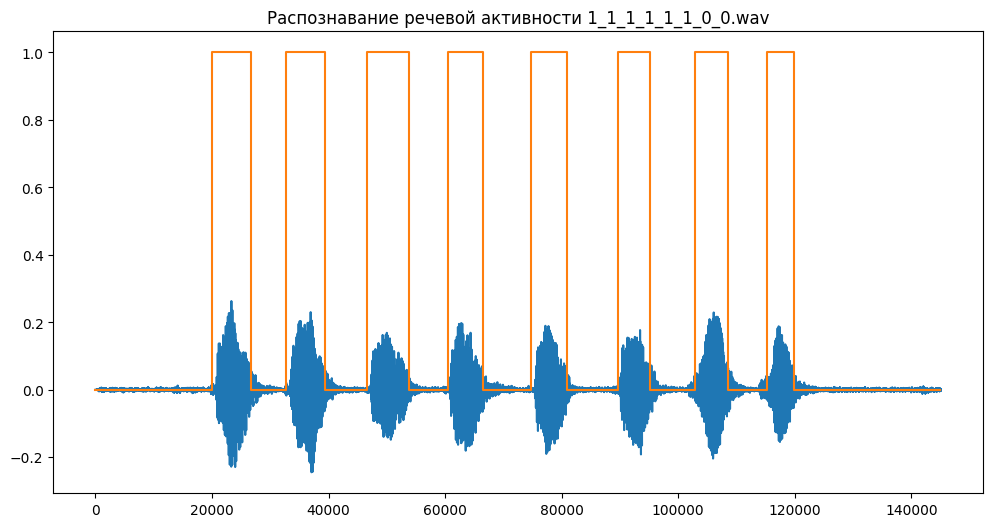

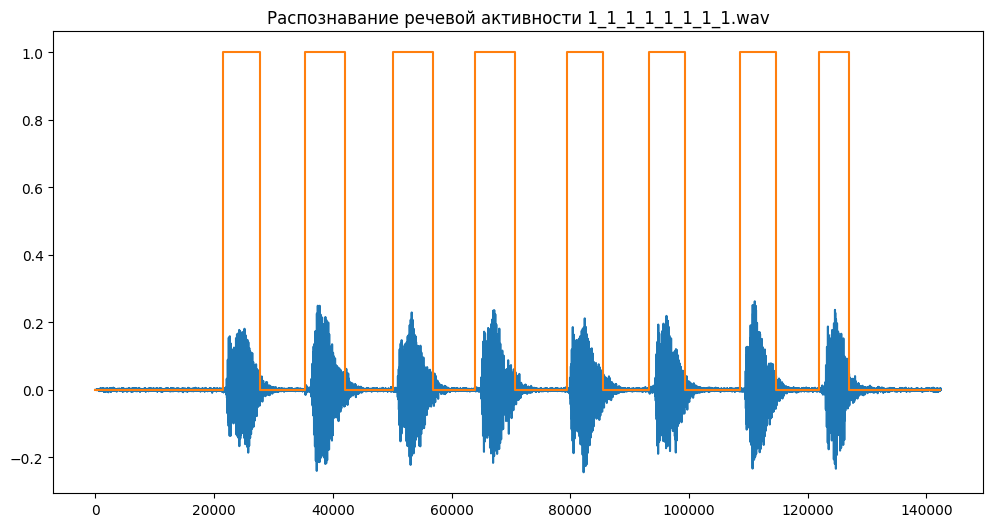

In [44]:
treshold = 0.025
segments_files = []

for fw in range(len(files)):
    audio_file =  os.path.join(direc,files[fw])
    audio, sr = librosa.load(audio_file)

    S_full, phase = librosa.magphase(librosa.stft(audio))
    rms = librosa.feature.rms(y=audio)[0]
    times = librosa.frames_to_samples(np.arange(len(rms)))
    r_normalized = (rms - treshold) / np.std(rms)
    p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
    plt.figure(figsize=(12, 6))
    plt.plot(audio)
    plt.step(times, p>=0.5, label='Non-silent')
    plt.title('Распознавание речевой активности ' + files[fw])
    
    segments = []
    start = None
    
    for i in range(len(times)):
        if p[i] >= 0.5 and start is None:
            start = times[i]
        elif p[i] < 0.5 and start is not None:
            segments.append([start,times[i]])
            start = None
    segments_files.append(segments)
            
    #print(segments[fw])

In [10]:
# segments_files

In [45]:
X_train, X_test, labels_train, labels_test, files_train, files_test,segments_files_train, segments_files_test = train_test_split(X, labels, files, segments_files, 
                                                                                       test_size=0.2, random_state=42)


## Task 5

После того как мы узнали сегменты аудио с речью, то можно перейти к самой задаче классификации. \
Внимательно изучи функцию [make_dataset](code-samples/audio_utils.py). С помощью этой функции cгенерируй X, Y для train и test выборок.
Затем попробуй обучить различные классификаторы. Например, SVM или LogisticRegression.
Измерь точность (accuracy) классификации на тестовой выборке.

In [46]:
def make_dataset(samples, labels, vad_segments):
    """

    :param samples: Список аудио сигналов
    :param labels: Список меток (Например для файла '0_0_0_1_0_1_1_0.wav': [0, 0, 0, 1, 0, 1, 1, 0])
    :param vad_segments: Список сегментов для каждого аудио сигнала вида:
        [
            [[23996, 32539], [35410, 44925], ...,],
            [[22141, 30259], [34917, 42695], ...,],
            ...
        ]
    :return:
    """
    X, y = [], []
    # Проходим по каждому аудио сигналу
    for sample in range(len(samples)):
        # В аудио сигнале проходим по каждому сегменту с речью
        for segment in range(len(vad_segments[sample]) - 1):
            start = vad_segments[sample][segment][0]  # Начало сегмента
            stop = vad_segments[sample][segment][1]  # Конец сегмента
            voice = samples[sample][start:stop]  # Отрезаем сегмент с речью из аудио сигнала и применяем stft
            stft = librosa.stft(voice).mean(axis=1)
            stft_db = librosa.amplitude_to_db(abs(stft))

            X.append(stft_db)  # Добавляем спектрограмму с речью
            y.append(labels[sample][segment])  # Добавляем метку для этой спектрограммы

    return np.array(X), np.array(y)

In [47]:
# Код тут
Xx_train, y_train = make_dataset(X_train, labels_train, segments_files_train)
Xx_test, y_test = make_dataset(X_test, labels_test, segments_files_test)

In [50]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score

clf = svm.SVC(kernel='rbf')   #  функция ядра - RBF (радиальная базисная функция)
clf.fit(Xx_train, y_train)     # Обучение модели на тренировочном наборе
y_pred = clf.predict(Xx_test)    


print("Accuracy по обучающей выборке: ", accuracy_score(y_train, clf.predict(Xx_train)))
print("Accuracy по тестовой выборке: ",accuracy_score(y_test, y_pred) )

Accuracy по обучающей выборке:  1.0
Accuracy по тестовой выборке:  1.0


In [51]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(solver='liblinear', fit_intercept=False, penalty='l1', random_state=21)# создаем модель
model.fit(Xx_train, y_train)# обучаем модель на train-выборке
y_pred = model.predict(Xx_test)# делаем предсказания на test-выборке
accuracy = accuracy_score(y_test, y_pred)# считаем точность accuracy

print('Accuracy:', accuracy)

Accuracy: 1.0
